### For time-series forcasting:
1. Handle bad values in the dataframe (Done)
2. Calculate hourly sentiment score (Done)
3. Handle missing values in the time series (min/max scaler, average scaler) (No need, because we're doing monthly resampling)
4. Create time-series model for predicting the last few observations (In-progress)
5. Compare different time-series models (In-progress)
6. Fine-tune the models for your dataset (In-progress)

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
import glob
from sklearn.metrics import mean_absolute_error

matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
plt.rcParams.update({'font.size': 23})

In [2]:
def getDailySentiment(dataframe, column):
    # Get daily total tweets
    dailyTweets = (dataframe.groupby([dataframe[column]])['tweet'].count()).to_frame('totalDailyTweets')
    
    # Group the tweets by day, sentiment and get their count
    sentiments_per_day = (dataframe.groupby([column,'sentiment'])['tweet'].count()).to_frame('sentimentTweetCount')
    
    # Get the sentiment with maximum number of tweets in that day. Change sentiment from dataframe index to dataframe column.
    dailySentiment = sentiments_per_day.loc[sentiments_per_day.groupby([column], sort=False)['sentimentTweetCount'].idxmax()][['sentimentTweetCount']]
    dailySentiment.reset_index(level=['sentiment'], inplace=True)
    
    # Merge total tweets per hour and hourly sentiment dataframe
    dailySentiment = dailySentiment.merge(dailyTweets, on=column, how='inner')
    
    # Calculate hourly score wrt to the maximum number of tweets for a sentiment
    dailyScore = []
    for index, row in dailySentiment.iterrows():
        if row['sentiment'] == 'positive':
            dailyScore.append(np.round(row['sentimentTweetCount']/row['totalDailyTweets'], 3))
        elif row['sentiment'] == 'negative':
            dailyScore.append(-1*np.round(row['sentimentTweetCount']/row['totalDailyTweets'], 3))
        else:
            dailyScore.append(0)
    dailySentiment['dailySentimentScore'] = dailyScore
    
    return dailySentiment

In [3]:
# Constants
PHARMA_PATH = '../../../data/twitter/combined data/pharma companies'
GOVT_INSTITUTES_PATH = '../../../data/twitter/combined data/public health agencies'
NGO_PATH = '../../../data/twitter/combined data/ngo'

In [4]:
df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob(NGO_PATH + "/*.csv")],ignore_index=True)
# Divide as per dates
pre_covid_df = df.loc[df['created_at'] <= '2020-02-26 23:59:59']
print(pre_covid_df.shape)

during_covid_df = df.loc[df['created_at'] >= '2020-02-26 00:00:00']
print(during_covid_df.shape)

(24800, 17)
(19303, 17)


In [5]:
pre_covid_df['created_at'] = pre_covid_df['created_at'].str[:-6]
pre_covid_df['created_at'] = pd.to_datetime(pre_covid_df['created_at'])
pre_covid_df['date'] = pre_covid_df['created_at'].dt.date

# Sort by datetime ascending
pre_covid_df = pre_covid_df.sort_values(by='date')

# Drop extra columns
extra_cols = ['id','retweet_count','like_count','reply_count','quote_count','expanded_url','language','possibly_sensitive','in_reply_to_user_id','positive','negative','neutral']
pre_covid_df.drop(extra_cols, axis=1, inplace=True)

dailySentiment_df = getDailySentiment(pre_covid_df, 'date')
dailySentiment_df.index = pd.to_datetime(dailySentiment_df.index, errors='coerce')

In [6]:
train_len = int(dailySentiment_df.shape[0]*0.8)
dailySentiment_df.iloc[train_len]

sentiment              negative
sentimentTweetCount           8
totalDailyTweets             17
dailySentimentScore      -0.471
Name: 2019-07-12 00:00:00, dtype: object

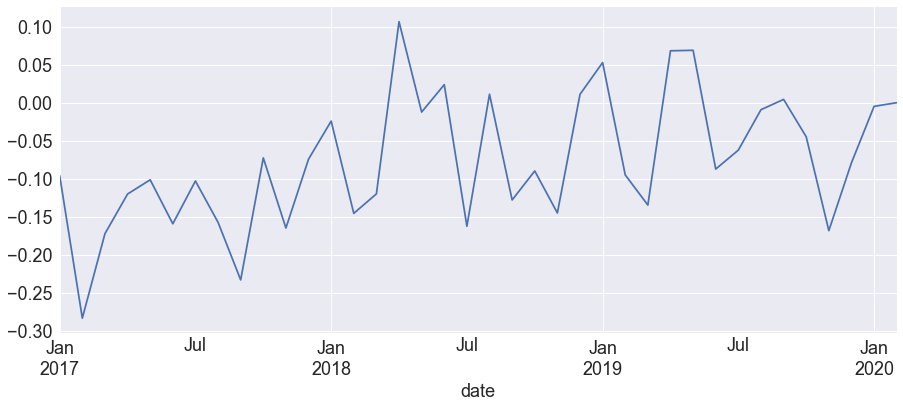

In [7]:
# Resample the data to the month starting
y = dailySentiment_df['dailySentimentScore'].resample('MS').mean()
y.plot(figsize=(15,6))
plt.show()

In [8]:
# Time series decomposition-trend, seasonality & noise
# decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# decomposition.plot()
# plt.show()

In [9]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            # mod = sm.tsa.statespace.
            results = mod.fit()
            print('ARIMA {} x {}, AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12), AIC:-52.50494307283773
ARIMA (0, 0, 0) x (0, 0, 1, 12), AIC:898.4144626738182
ARIMA (0, 0, 0) x (0, 1, 0, 12), AIC:-42.588942282969704
ARIMA (0, 0, 0) x (0, 1, 1, 12), AIC:-26.593488604146085
ARIMA (0, 0, 0) x (1, 0, 0, 12), AIC:-61.801331420554035
ARIMA (0, 0, 0) x (1, 0, 1, 12), AIC:849.4673713199178
ARIMA (0, 0, 0) x (1, 1, 0, 12), AIC:-28.739765822825433


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 1, 1, 12), AIC:-24.751128339628938
ARIMA (0, 0, 1) x (0, 0, 0, 12), AIC:-61.82074363823878
ARIMA (0, 0, 1) x (0, 0, 1, 12), AIC:1008.0586529952425
ARIMA (0, 0, 1) x (0, 1, 0, 12), AIC:-40.15895385523979
ARIMA (0, 0, 1) x (0, 1, 1, 12), AIC:-22.654924397871937
ARIMA (0, 0, 1) x (1, 0, 0, 12), AIC:-60.300226660102226


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 0, 1, 12), AIC:1006.8449259845966
ARIMA (0, 0, 1) x (1, 1, 0, 12), AIC:-28.79345955822439
ARIMA (0, 0, 1) x (1, 1, 1, 12), AIC:-20.744439119791092
ARIMA (0, 1, 0) x (0, 0, 0, 12), AIC:-58.10693022025774


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 0) x (0, 0, 1, 12), AIC:1037.2901851820557
ARIMA (0, 1, 0) x (0, 1, 0, 12), AIC:-29.27402506747209
ARIMA (0, 1, 0) x (0, 1, 1, 12), AIC:-17.679234964398223
ARIMA (0, 1, 0) x (1, 0, 0, 12), AIC:-38.44567492397405
ARIMA (0, 1, 0) x (1, 0, 1, 12), AIC:-35.39081342194715
ARIMA (0, 1, 0) x (1, 1, 0, 12), AIC:-21.59951681265691
ARIMA (0, 1, 0) x (1, 1, 1, 12), AIC:-16.730815839371086
ARIMA (0, 1, 1) x (0, 0, 0, 12), AIC:-69.50142933382719
ARIMA (0, 1, 1) x (0, 0, 1, 12), AIC:943.0464053551684
ARIMA (0, 1, 1) x (0, 1, 0, 12), AIC:-41.803891931139454
ARIMA (0, 1, 1) x (0, 1, 1, 12), AIC:-18.54873333864878


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 1) x (1, 0, 0, 12), AIC:-53.096445615555986
ARIMA (0, 1, 1) x (1, 0, 1, 12), AIC:-45.29721820854564
ARIMA (0, 1, 1) x (1, 1, 0, 12), AIC:-23.894802751856417
ARIMA (0, 1, 1) x (1, 1, 1, 12), AIC:-17.464968289281206
ARIMA (1, 0, 0) x (0, 0, 0, 12), AIC:-64.97574765185065
ARIMA (1, 0, 0) x (0, 0, 1, 12), AIC:1072.1623379267673
ARIMA (1, 0, 0) x (0, 1, 0, 12), AIC:-41.703639347451734
ARIMA (1, 0, 0) x (0, 1, 1, 12), AIC:-25.042130232296095
ARIMA (1, 0, 0) x (1, 0, 0, 12), AIC:-56.73165123860966


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (1, 0, 1, 12), AIC:1070.8147056239754
ARIMA (1, 0, 0) x (1, 1, 0, 12), AIC:-25.04215185015541
ARIMA (1, 0, 0) x (1, 1, 1, 12), AIC:-23.08968191924977
ARIMA (1, 0, 1) x (0, 0, 0, 12), AIC:-77.7530088565552


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (0, 0, 1, 12), AIC:1031.5362072645974
ARIMA (1, 0, 1) x (0, 1, 0, 12), AIC:-48.48206635215843
ARIMA (1, 0, 1) x (0, 1, 1, 12), AIC:-20.749266728978093
ARIMA (1, 0, 1) x (1, 0, 0, 12), AIC:-56.428877807284735


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (1, 0, 1, 12), AIC:1030.322480219856
ARIMA (1, 0, 1) x (1, 1, 0, 12), AIC:-25.27187161282172
ARIMA (1, 0, 1) x (1, 1, 1, 12), AIC:-20.569117107138663
ARIMA (1, 1, 0) x (0, 0, 0, 12), AIC:-62.288566708190274
ARIMA (1, 1, 0) x (0, 0, 1, 12), AIC:979.5539216191206
ARIMA (1, 1, 0) x (0, 1, 0, 12), AIC:-41.9973206960821
ARIMA (1, 1, 0) x (0, 1, 1, 12), AIC:-17.845272590998498
ARIMA (1, 1, 0) x (1, 0, 0, 12), AIC:-42.09228070841456


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (1, 0, 1, 12), AIC:-40.15943056732766
ARIMA (1, 1, 0) x (1, 1, 0, 12), AIC:-17.84527795198925
ARIMA (1, 1, 0) x (1, 1, 1, 12), AIC:-15.846137019015408
ARIMA (1, 1, 1) x (0, 0, 0, 12), AIC:-67.52028102623164


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (0, 0, 1, 12), AIC:959.5773899537853
ARIMA (1, 1, 1) x (0, 1, 0, 12), AIC:-41.91627623766964
ARIMA (1, 1, 1) x (0, 1, 1, 12), AIC:-16.591437999158025
ARIMA (1, 1, 1) x (1, 0, 0, 12), AIC:-48.111730718879784
ARIMA (1, 1, 1) x (1, 0, 1, 12), AIC:-44.10532167256831
ARIMA (1, 1, 1) x (1, 1, 0, 12), AIC:-19.251310038536747
ARIMA (1, 1, 1) x (1, 1, 1, 12), AIC:-15.754635016755515


In [10]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                # enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1948      0.381     -0.512      0.609      -0.941       0.551
ma.L1         -0.7448      0.263     -2.830      0.005      -1.261      -0.229
ar.S.L12      -0.9717      3.879     -0.250      0.802      -8.575       6.632
ma.S.L12       0.8058     12.908      0.062      0.950     -24.494      26.105
sigma2         0.0047      0.041      0.116      0.908      -0.075       0.085


C:\Users\manme\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


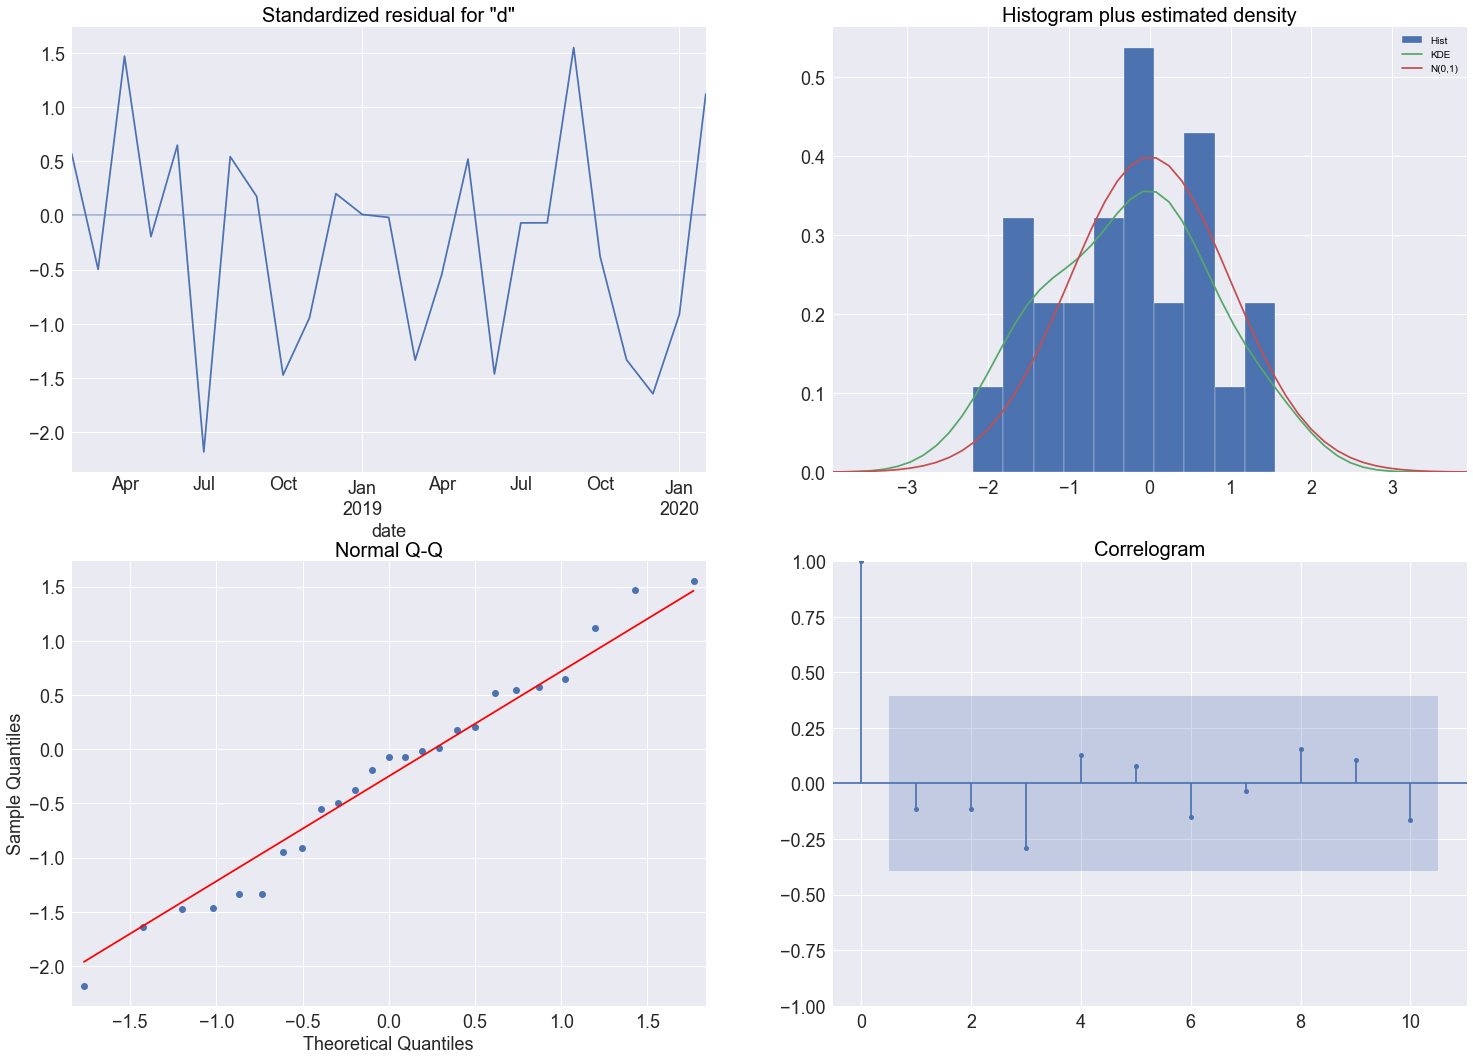

In [11]:
results.plot_diagnostics(figsize=(25, 18))
plt.rcParams['axes.titlepad'] = 15
plt.savefig('plot diagnostics.pdf', bbox_inches='tight')
plt.savefig('plot diagnostics.png', bbox_inches='tight')
plt.show()

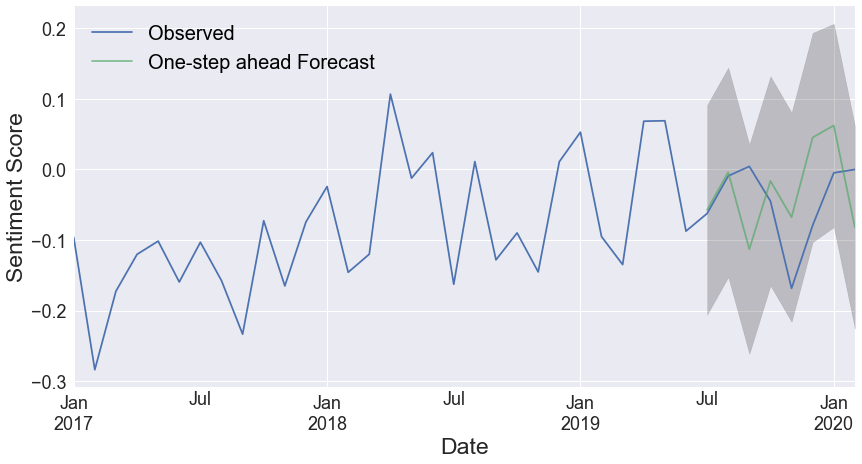

In [12]:
pred = results.get_prediction(start=pd.to_datetime('2019-07-01'), dynamic=False)
pred_ci = pred.conf_int()
plt.figure(figsize=(14, 8))
ax = y['2017':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
ax.xaxis.label.set_size(23)
ax.yaxis.label.set_size(23)
plt.legend(loc=2, prop={'size':20})
plt.savefig('pharma.pdf', bbox_inches='tight')
plt.savefig('pharma.png', bbox_inches='tight')
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-07-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 3)))

In [ ]:
print('MAE:', mean_absolute_error(y_truth, y_forecasted))